# An analysis of Department of Health and Human Services Funding in California

## Rodrigo González Laiz & Katie Truong

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [84]:
import numpy as np
import pandas as pd

import bokeh
from bokeh.io import show
from bokeh.models import LogColorMapper, CustomJS, Toggle, ColumnDataSource, CDSView, GroupFilter
from bokeh.palettes import Viridis6 as palette
from bokeh.plotting import figure
from bokeh.layouts import column, row, widgetbox 

from bokeh.models.widgets import Slider
from bokeh.models import LogColorMapper, LogTicker, ColorBar
from bokeh.layouts import Column

from bokeh.sampledata.us_counties import data as counties


bokeh.io.output_notebook()

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import plotnine as p9
from plotnine import *
pd.options.display.max_rows = 4000

sns.set_style("darkgrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
p9.options.figure_size = (10, 7.5)

import plotly.plotly as py
import plotly.graph_objs as go

import numpy as np
from sklearn import datasets, linear_model

Loading BokehJS ...

# Introduction and Motivation:

Among all agencies in the US, Department of Health and Human Services is the biggest spender (which takes up to 25.4% among of all the funding in 2018). In this project, we want to explore the funding of Department of Health and Human Services in California, one of the biggest states in the United States. Our project includes two parts:

**1. Analysis:**

In this section, we would go over the funding and awarding of Department of Health and Human Services (HHS) in California in from 2000 to 2018, analyze the trend and categories of spending over the years, the demographic features that may affect the spending, etc...

**2. Classification:**

We observe that around 30% of the spendings are missing the county that was awarded. We want to train a classifier that would fill out the locations that are missing based on other features in the dataset.

## 1. Analysis of Department of Health and Human Services awards in California:

First, we can look at the total obligation of each county for every year from 2000 to 2018 (we excluded 2019 because there are very few transactions).

In [3]:
def county_name_format(name):
    final_name = ""
    try:
        if type(name) != 'float':
            words = name.split(" ")
            if (words[-1] == 'COUNTY') or (words[-1] == '(COUNTY)'):
                words.pop()
            for i in range(0, len(words)):
                final_name += words[i].capitalize() + " "
            final_name = final_name.rstrip()
        else:
            final_name = np.nan
    except:
        pass
    return(final_name)

In [66]:
df = pd.read_csv("clean.csv")
df['total_obligation'] = df['total_obligation'] / 1000000 #unit: 1 million dollars
df = df.sort_values(by=['fiscal_year', 'recipient_unique_id'])
cols_to_drop = [0]
df.drop(df.columns[cols_to_drop],axis=1,inplace=True)
df = df.fillna(0)
df['recipient_unique_id'] = df['recipient_unique_id'].apply(lambda x: int(x) if x == x else "")
df['recipient_location_county_name'] = df['recipient_location_county_name'].apply(lambda x: county_name_format(x) if x == x else "")
df = df[(df['recipient_location_county_name']!='')&(df['recipient_location_county_name']!=0)]
df = df[df['fiscal_year'] != 2019]

In [67]:
total = df.groupby(['fiscal_year', 'recipient_location_county_name'])['total_obligation'].sum().reset_index().sort_values(by=['fiscal_year','total_obligation'], ascending=False)

In [68]:
total_top_five = total.groupby('fiscal_year').head(5)

In [69]:
total_top_five['log_obligation'] = np.log(total_top_five['total_obligation'])

The funding/awarding amount of Department of Health and Human Services for each county in California differ greatly across the counties across the years, with a median of 30.71 million USD in 2008, and 100.59 million USD in 2018. It also has a very large standard deviation, 1770 million USD in 2008, and 12,420 million USD in 2018, which signifies either a the difference in awarding/funding amount, or a difference in transaction documentating of each county, or both.

We can also notify a significant shift in funding/spending between 2006 and 2007, which may be attributed to documentation process, rather than the amount of actual spending.

In [70]:
total.groupby(['fiscal_year']).describe()

total_obligation                                          \
                       count          mean            std        min   
fiscal_year                                                            
2001                    51.0     45.129742     134.938599 -13.082421   
2002                    51.0     89.709537     217.592965  -0.479897   
2003                    50.0    124.639812     388.936809  -0.813250   
2004                    52.0     86.870998     221.031137   0.004250   
2005                    52.0    130.146453     342.645334   0.015000   
2006                    50.0    123.465576     338.489511  -0.002122   
2007                    55.0   3353.237755   18184.133648  -0.354671   
2008                    58.0   3682.206249   17772.213220   1.366586   
2009                    58.0   7193.378571   33387.947824   7.825844   
2010                    58.0   7103.627934   40519.472241   2.264478   
2011                    55.0  12870.403679   80375.069857   0.095913   
2012                    55.0   9420.729921   54072.392133   3.447762   
2013                    56.0   8180.159820   45022.596465   0.716848   
2014                    57.0  10401.033998   62239.199744   0.716848   
2015                    56.0   9857.389175   55916.971871   0.009691   
2016                    57.0   8478.663288   47612.327554   0.050000   
2017                    55.0   8320.597519   40999.165123   0.050000   
2018                    57.0  19973.980007  124283.478038   0.010000   

                                                                  
                    25%          50%          75%            max  
fiscal_year                                                       
2001          -0.037639     1.093095    11.927677     754.276849  
2002           2.330340    11.232749    35.268529     953.590445  
2003           0.720075     2.832889    28.479900    2351.242754  
2004           1.150512     3.254087    22.858158     962.616229  
2005           1.845957     6.592121    30.728883    1847.220692  
2006           1.604328     5.142946    29.573372    1845.699802  
2007          44.570726   199.189293   735.444458  134852.312354  
2008         105.572788   371.001842  1075.673309  134166.595836  
2009         200.443697   838.731977  2220.286257  252371.568182  
2010          99.390933   387.965330  1485.387736  308703.641897  
2011          88.988605   616.814315  2039.219308  597201.140380  
2012         158.171091   520.210197  1573.564710  401416.014359  
2013         155.212353   577.220241  1818.080700  336747.912101  
2014         135.797918   671.388880  1481.344950  470229.640730  
2015         116.379681   513.017505  1470.419035  418297.109238  
2016          69.338469   552.712149  1440.843718  358664.547229  
2017         119.215524   701.317814  1643.366259  301697.836166  
2018         180.797175  1059.408483  2727.983194  939267.643311

Sacramento, Los Angeles, San Diego, San Francisco, Alameda, Santa Clara, Yolo, etc... are the counties that frequently appear in the top five spending counties of every year, whith Sacramento (the capitol of California) being the top of every year.

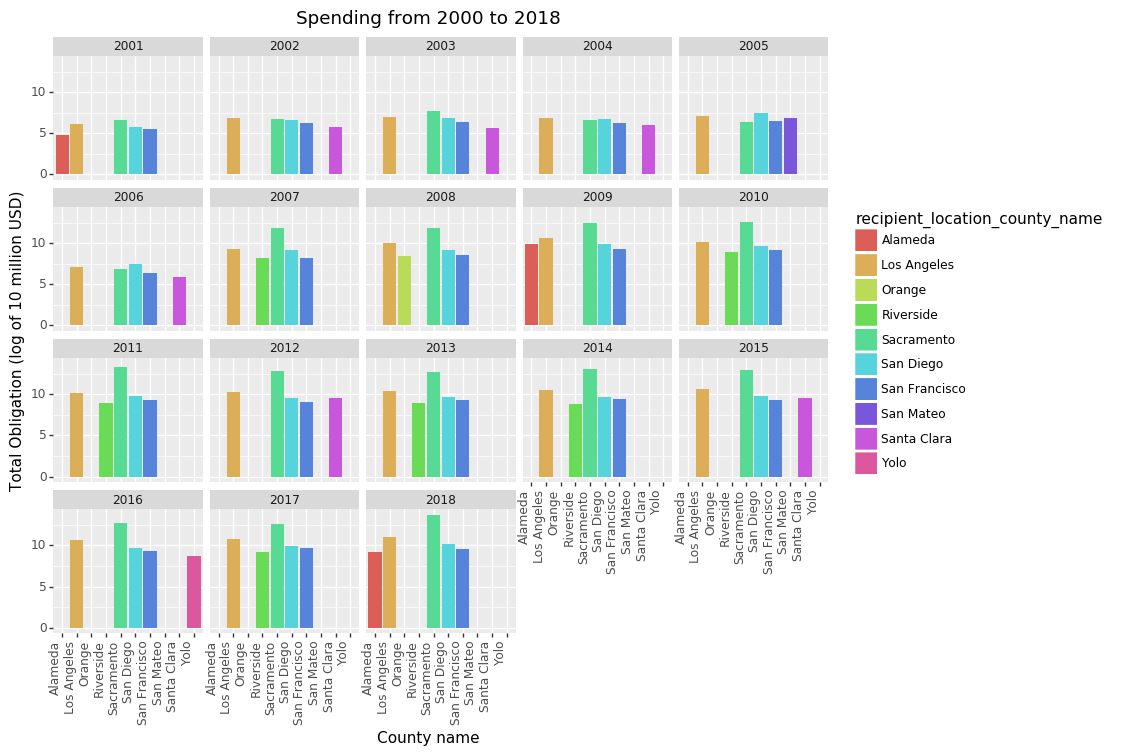

<ggplot: (-9223372029290602478)>

In [71]:
(
    p9.ggplot(aes(x='recipient_location_county_name', y='log_obligation', fill='recipient_location_county_name'), data = total_top_five) 
        + p9.geom_bar(stat='identity', position='dodge')
        + p9.facet_wrap('~fiscal_year)')
        + p9.labs(title='Spending from 2000 to 2018') 
        + p9.labels.ylab('Total Obligation (log of 10 million USD)')
        + p9.labels.xlab('County name')
        + p9.theme(axis_text_x = element_text(angle = 90, hjust = 1))
)


We can also see the amount funded/awarded to every county in California with this interactive map (unit: $10 million USD). Overall, over the years, the funding among every county has increased significantly, with Sacramento always being the top one.

In [72]:
counties_ca = {
    code: county for code, county in counties.items() if (county["state"] == "ca")
}

county_xs = [county["lons"] for county in counties_ca.values()]
county_ys = [county["lats"] for county in counties_ca.values()]
county_names = [county['name'] for county in counties_ca.values()]

def replace_nan(county_info):
    for l in county_info:
        for idx, item in enumerate(l):
            if np.isnan(item):
                l[idx] = np.nanmean(l)
    return(county_info)

county_xs = replace_nan(county_xs)
county_ys = replace_nan(county_ys)

In [73]:
sum_obligation = df.groupby(['fiscal_year','recipient_location_county_name'])['total_obligation'].sum().reset_index()
sum_obligation = sum_obligation[(sum_obligation['recipient_location_county_name']!= '') & (sum_obligation['fiscal_year']!= 2019)]

In [74]:
years = sum_obligation['fiscal_year'].unique()

for year in years:
    sub = sum_obligation[sum_obligation['fiscal_year']==year]
    temp = pd.DataFrame(columns=['fiscal_year', 'recipient_location_county_name', 'total_obligation'])
    for county in county_names:
        if county not in sub['recipient_location_county_name'].unique():
            temp = temp.append({'fiscal_year': year, 'recipient_location_county_name': county, 'total_obligation': 0}, ignore_index=True)
    for county in sub['recipient_location_county_name'].unique():
        if county not in county_names:
            sum_obligation = sum_obligation[sum_obligation['recipient_location_county_name']!= county]
    sum_obligation = sum_obligation.append(temp)
    

In [75]:
sum_obligation = sum_obligation.sort_values(by=['fiscal_year', 'recipient_location_county_name']).reset_index()

In [76]:
years = sum_obligation['fiscal_year'].unique()
data_list = []
for year in years:
    data = dict(
        x=county_xs,
        y=county_ys,
        name=county_names,
        year=str(year),
        rate=sum_obligation[sum_obligation['fiscal_year']==year]['total_obligation']
    )
    data_list.append(data)
plot_df = pd.DataFrame(data_list[0])
for i in range(1, len(data_list)):
    try:
        temp = pd.DataFrame(data_list[i])
        plot_df = plot_df.append(temp)
    except:
        print(i)

In [85]:
# Plotting with bokeh

data = ColumnDataSource(plot_df)
view = CDSView(source = data, filters = [GroupFilter(column_name = "year", group = "2001")])
color_mapper = LogColorMapper(palette="Viridis256", low=0, high=1e6)

TOOLS = "pan,wheel_zoom,reset,hover,save"

p = figure(
    title="CA spending", tools=TOOLS,
    x_axis_location=None, y_axis_location=None,
    tooltips=[
        ("Name", "@name"), ("Spending)", "@rate"), ("(Long, Lat)", "($x, $y)")
    ])

p.grid.grid_line_color = None
p.hover.point_policy = "follow_mouse"

p.patches('x', 'y', source=data, view = view,
          fill_color={'field': 'rate', 'transform': color_mapper},
          fill_alpha=0.7, line_color="white", line_width=0.5)

color_bar = ColorBar(color_mapper=color_mapper, ticker=LogTicker(),
                     label_standoff=12, border_line_color=None, location=(0,0))

p.add_layout(color_bar, 'right')

callback = CustomJS(args = {"source": data, "view": view}, code = """
    view.filters[0].group = cb_obj.value.toString();
    source.change.emit();
""")

slider = Slider(start=2001, end=2018, value=2001, title="Year")

slider.js_on_change("value", callback)


layout = Column(slider,p)
show(layout)

## B. What are the categories that receive the most money?

In [16]:
categories = df.groupby(['awarding_subtier_agency_name'])['total_obligation'].sum().reset_index().sort_values(by='total_obligation', ascending=False)

In [17]:
categories.head(10)

,awarding_subtier_agency_name,total_obligation
6,Centers for Medicare and Medicaid Services,42072.276472
0,Administration for Children and Families,8068.927089
21,Health Resources and Services Administration,3995.213817
24,National Institutes of Health,3919.327049
23,Indian Health Service,1895.651502
5,Centers for Disease Control and Prevention,544.105848
10,Department of Energy,305.429598
27,Office of Assistant Secretary for Preparedness...,247.915363
36,Substance Abuse and Mental Health Services Adm...,207.918068
22,Immediate Office of the Secretary,127.153123


In [18]:
medi = df[df['awarding_subtier_agency_name']=='Centers for Medicare and Medicaid Services'].groupby(['fiscal_year'])['total_obligation'].sum().reset_index().sort_values(by='fiscal_year', ascending=False)

In [19]:
medi

,fiscal_year,total_obligation
17,2018,8940.990837
16,2017,2589.688053
15,2016,3313.001221
14,2015,3874.466932
13,2014,4488.046886
12,2013,2895.424913
11,2012,3489.332132
10,2011,5186.294974
9,2010,2617.353866
8,2009,2421.968690


We can see that most of the money funded by Department of Health and Human Services goes to health category, such as Centers for Medicare and Medicaid Services, Health Resources and Services Administration, National Institutes of Health, Indian Health Service, and Centers for Disease Control and Prevention. Administration for Children and Families and Department of Energy are also the top agencies that receive the most money.

## C. What's the correlation between the counties' population and demographics, and how they spend money?

To answer this question, we can look at [Census data in 2017](https://www.census.gov/quickfacts/ca) and compare it with how money was spent across county in 2017.


In [34]:
census = pd.read_csv('./aff_download/ACS_17_5YR_S0101_with_ann.csv')
labels = census.loc[0]

census = census.drop(census.index[[0]])

# Extract and convert useful columns to appropriate type

census.HC01_EST_VC37 = census.HC01_EST_VC37.astype(float).fillna(0.0)
census.HC03_EST_VC01 = census.HC03_EST_VC01.astype(float).fillna(0.0)
census.HC05_EST_VC01 = census.HC05_EST_VC01.astype(float).fillna(0.0)

census.HC01_EST_VC01 = census.HC01_EST_VC01.astype(float).fillna(0.0) # total pop

census.HC01_EST_VC03 = census.HC01_EST_VC03.astype(float).fillna(0.0) # total pop - under 5
census.HC02_EST_VC03 = census.HC02_EST_VC03.astype(float).fillna(0.0) # total percentage - under 5
census.HC01_EST_VC04 = census.HC01_EST_VC04.astype(float).fillna(0.0) # total pop - 5-9
census.HC02_EST_VC04 = census.HC02_EST_VC04.astype(float).fillna(0.0) # total percentage - 5-9
census.HC01_EST_VC05 = census.HC01_EST_VC05.astype(float).fillna(0.0) # total pop - 10-14
census.HC02_EST_VC05 = census.HC02_EST_VC05.astype(float).fillna(0.0) # total percentage - 10-14
census.HC01_EST_VC06 = census.HC01_EST_VC06.astype(float).fillna(0.0) # total pop - 15-19
census.HC02_EST_VC06 = census.HC02_EST_VC06.astype(float).fillna(0.0) # total percentage - 15-19

census.HC01_EST_VC15 = census.HC01_EST_VC15.astype(float).fillna(0.0) # 60-64
census.HC02_EST_VC15 = census.HC02_EST_VC15.astype(float).fillna(0.0)
census.HC01_EST_VC16 = census.HC01_EST_VC16.astype(float).fillna(0.0) # 65-69
census.HC02_EST_VC16 = census.HC02_EST_VC16.astype(float).fillna(0.0)
census.HC01_EST_VC17 = census.HC01_EST_VC17.astype(float).fillna(0.0) # 70-74
census.HC02_EST_VC17 = census.HC02_EST_VC17.astype(float).fillna(0.0)
census.HC01_EST_VC18 = census.HC01_EST_VC18.astype(float).fillna(0.0) # 75-79
census.HC02_EST_VC18 = census.HC02_EST_VC18.astype(float).fillna(0.0)
census.HC01_EST_VC19 = census.HC01_EST_VC19.astype(float).fillna(0.0) # 80-84
census.HC02_EST_VC19 = census.HC02_EST_VC19.astype(float).fillna(0.0)
census.HC01_EST_VC20 = census.HC01_EST_VC20.astype(float).fillna(0.0) # 85 and above
census.HC02_EST_VC20 = census.HC02_EST_VC20.astype(float).fillna(0.0)

# Calculate + rename 

census['HC01_EST_VC01'] = census['HC01_EST_VC01'] / 1000000

census['children_num'] = (census.HC01_EST_VC03 + census.HC01_EST_VC04 + census.HC01_EST_VC05 + census.HC01_EST_VC06) / 1000000
census['children_percentage'] = census.HC02_EST_VC03 + census.HC02_EST_VC04 + census.HC02_EST_VC05 + census.HC02_EST_VC06

census['elder_num'] = (census.HC01_EST_VC15 + census.HC01_EST_VC16 + census.HC01_EST_VC17 + census.HC01_EST_VC18 + census.HC01_EST_VC19 + census.HC01_EST_VC20) / 1000000
census['elder_percentage'] = census.HC02_EST_VC15 + census.HC02_EST_VC16 + census.HC02_EST_VC17 + census.HC02_EST_VC18 + census.HC02_EST_VC19 + census.HC02_EST_VC20

# Format county name in census data:
census['GEO.display-label'] = census['GEO.display-label'].apply(lambda name: name.replace(' County, California',''))

# Only extract what need from census data:
census_clean = census[['GEO.display-label', 'HC01_EST_VC37', 'HC03_EST_VC01', 'HC05_EST_VC01', 'HC01_EST_VC01','children_num', 'children_percentage', 'elder_num', 'elder_percentage']].copy()
census_clean.columns = ['county', 'median_age', 'male', 'female', 'total_population', 'children_num', 'children_percentage', 'elder_num', 'elder_percentage']

In [35]:
total_spending_in_2017 = df[df['fiscal_year'] == 2017].groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()

In [36]:
total_spending = total_spending_in_2017.merge(census_clean, left_on='recipient_location_county_name', right_on='county')

- **Population and obligation:**

There is a positive, but weak correlation (0.24) between the population of a county, and the amount of money it's funded/awarded. Sacremento is an outlier in the regression model.


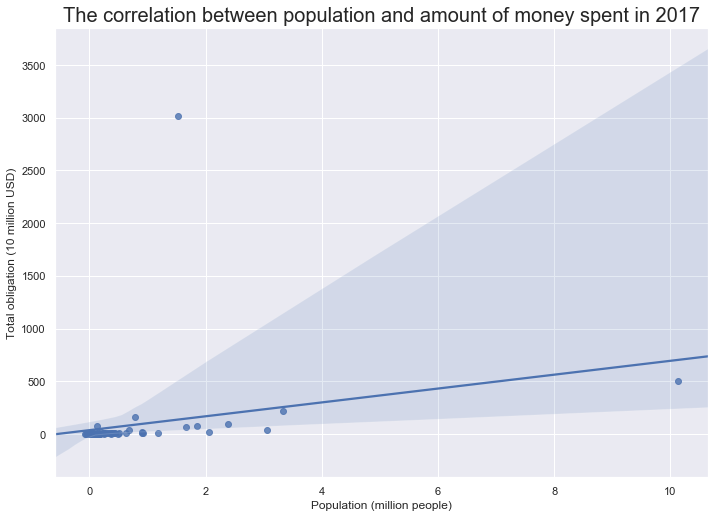

In [37]:
ax = sns.regplot(x="total_population", y="total_obligation", data=total_spending, x_jitter=.1)
ax.set_title('The correlation between population and amount of money spent in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

This may be because each (smaller) county would receive a base amount of award, which is not correlated to their population, and additional amount based on each unit of increasement in population. It also depends on the categories of the spending. We can investigate some categories in spending, to see which of them are more correlated to the population and the demographic of people living in that state.

**a. Health Resources and Services Administration**

In [38]:
health = df[(df['fiscal_year'] == 2017) & (df['awarding_subtier_agency_name'] == 'Health Resources and Services Administration')]
health_num = health.groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()
health_df = health_num.merge(census_clean, left_on='recipient_location_county_name', right_on='county')
health_df['special_num'] = health_df['children_num'] + health_df['elder_num']
health_df['money_spent_per_million_people'] = health_df['total_obligation'] / health_df['total_population']
health_df = health_df.sort_values(by='total_obligation', ascending=False)

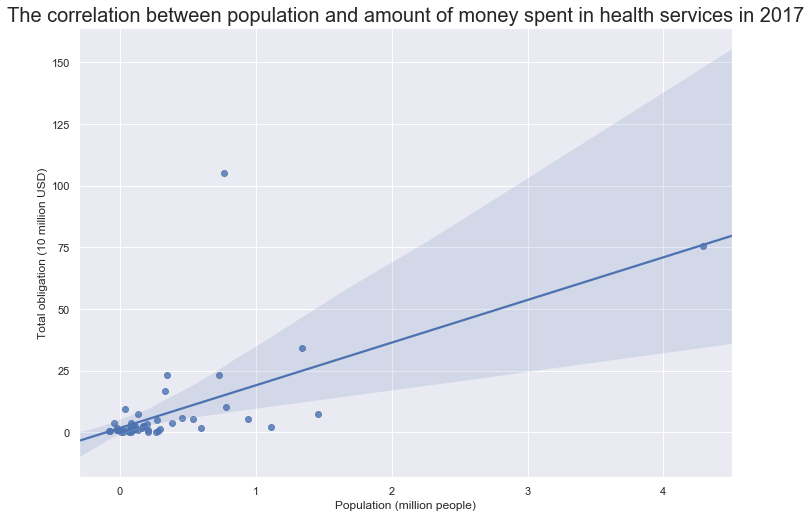

In [39]:
ax = sns.regplot(x="special_num", y="total_obligation", data=health_df, x_jitter=.1)
ax.set_title('The correlation between population and amount of money spent in health services in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

We can observe that the total population of one state and its amount of funding is more strongly correlated, being 0.63.

We can also look at the correlation between the number of children and elder in each counties, and its funding in health services. The plot of the number of children and elder vs the money spent has a similar shape to the last plot, indicates that the number of children and elder have as much as a similar effect to the funding as the total population. In other words, having more children and elder don't drive the funding in healthcare too much.

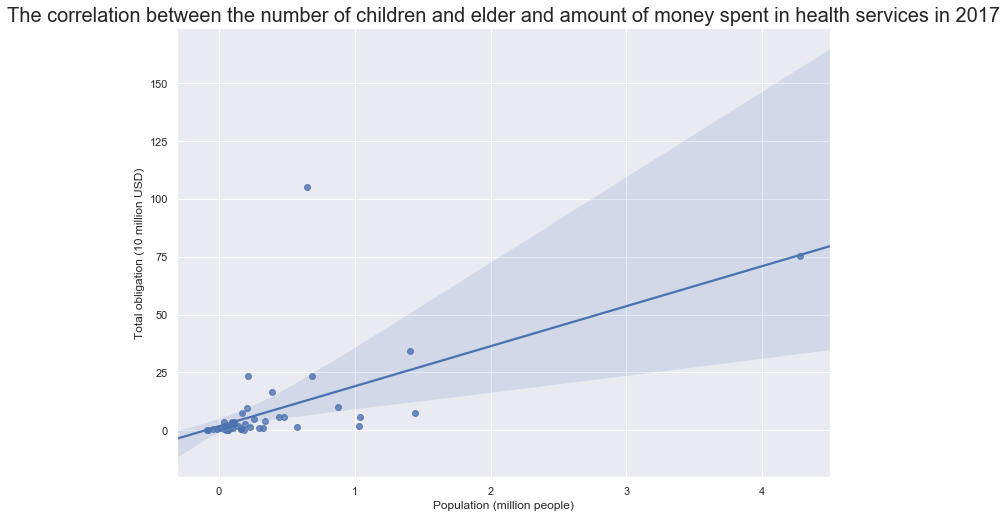

In [40]:
ax = sns.regplot(x="special_num", y="total_obligation", data=health_df, x_jitter=.1)
ax.set_title('The correlation between the number of children and elder and amount of money spent in health services in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()

**b. Health Resources and Services Administration**

In [41]:
substance = df[(df['fiscal_year'] == 2017) & (df['awarding_subtier_agency_name'] == 'Substance Abuse and Mental Health Services Administration')]
substance_num = substance.groupby(['recipient_location_county_name'])['total_obligation'].sum().reset_index()
substance_df = substance_num.merge(census_clean, left_on='recipient_location_county_name', right_on='county')
substance_df['money_spent_per_ten_million_people'] = substance_df['total_obligation'] / substance_df['total_population']
substance_df = substance_df.sort_values(by='money_spent_per_ten_million_people', ascending=False)

In [42]:
substance_df

,recipient_location_county_name,total_obligation,county,median_age,male,female,total_population,children_num,children_percentage,elder_num,elder_percentage,money_spent_per_ten_million_people
21,Sacramento,12.074412,Sacramento,35.9,730680.0,764720.0,1.495400,0.397045,26.5,0.279005,18.6,8.074370
2,Del Norte,0.048655,Del Norte,38.7,15008.0,12434.0,0.027442,0.006387,23.4,0.006262,22.8,1.773003
13,Mendocino,0.044937,Mendocino,42.4,43668.0,43829.0,0.087497,0.021022,24.0,0.024313,27.8,0.513581
5,Humboldt,0.062724,Humboldt,37.7,67508.0,67982.0,0.135490,0.031163,23.0,0.031200,23.0,0.462939
24,San Francisco,0.393727,San Francisco,38.3,440633.0,423630.0,0.864263,0.129814,14.9,0.179193,20.7,0.455563
6,Inyo,0.008126,Inyo,45.6,9172.0,9023.0,0.018195,0.004101,22.6,0.005588,30.7,0.446630
0,Alameda,0.696792,Alameda,37.3,799649.0,829966.0,1.629615,0.384443,23.6,0.300276,18.4,0.427581
34,Tehama,0.026494,Tehama,41.1,31452.0,31795.0,0.063247,0.016422,25.9,0.015876,25.0,0.418892
16,Nevada,0.038871,Nevada,49.8,48732.0,50106.0,0.098838,0.019394,19.7,0.033612,34.1,0.393282
31,Siskiyou,0.011992,Siskiyou,47.9,21706.0,21824.0,0.043530,0.009715,22.3,0.014018,32.2,0.275484


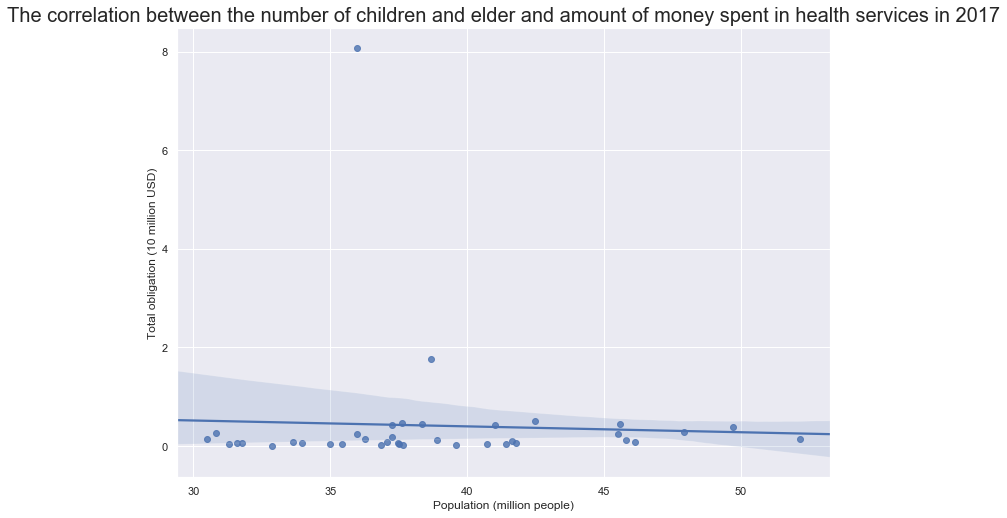

In [43]:
ax = sns.regplot(x="median_age", y="money_spent_per_ten_million_people", data=substance_df, x_jitter=.1)
ax.set_title('The correlation between the number of children and elder and amount of money spent in health services in 2017', fontsize=20)
ax.set_xlabel('Population (million people)')
ax.set_ylabel('Total obligation (10 million USD)')
plt.show()